In [1]:
import csv
import re
import subprocess

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from collections import defaultdict

In [4]:
from pysam import FastaFile
from Bio.Seq import reverse_complement

In [5]:
mmus_genome = FastaFile(
    "../data/ref/mus_musculus/fa/Mus_musculus.GRCm39.dna_sm.toplevel.fa.gz")

In [6]:
fe_w_new_ss = set()

In [7]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, pos, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon_type != "FE":
            continue

        if "homo_sapiens" in pos_group \
                and "mus_musculus" in neg_group:
            fe_w_new_ss.add(exon)

In [8]:
candidates = {
    'FE_FE': set(),
    'FE_NE': set(),
    'IE_IE': set(),
    'IE_NE': set()
}

In [9]:
with open("../data/homology/exons/hsap_mmus.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        hsap_exon, hsap_type, mmus_exon, mmus_type = row
        hsap_mmus = f"{hsap_type}_{mmus_type}"

        if hsap_mmus in candidates:
            if hsap_type == "FE" \
                    and hsap_exon not in fe_w_new_ss:
                continue

            chrom, *pos = re.split('[:-]', mmus_exon)
            beg, end, strand = map(int, pos)

            if strand:
                beg, end = beg - 150, beg + 50
            else:
                beg, end = end - 50, end + 150

            candidates[hsap_mmus].add((chrom, beg, end, strand))

In [10]:
long_data = list()

In [11]:
with open(f"../data/fimo/-150_+50.fa", 'w') as f:
    for hsap_mmus in candidates:
        for i, (chrom, beg, end, strand) in enumerate(candidates[hsap_mmus]):
            seq = mmus_genome.fetch(chrom, beg, end).upper()

            if strand == 0:  # i.e., reverse-stranded
                seq = reverse_complement(seq)

            if len(seq) != 200:
                continue

            gc_content = seq.count("G") + seq.count("C") / 200
            long_data.append({
                'hsap_mmus': hsap_mmus,
                'gc_content': gc_content,
            })

            f.write(f">{hsap_mmus}={chrom}-{beg}-{end}-{strand}\n" + f"{seq}\n")

In [12]:
frame = pd.DataFrame(long_data)

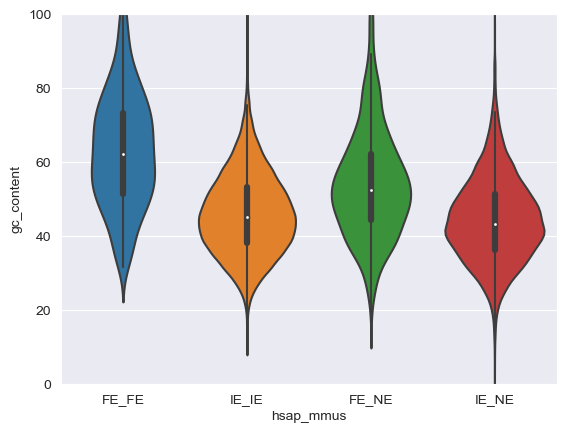

In [13]:
sns.violinplot(frame, x='hsap_mmus', y='gc_content', order=["FE_FE", "IE_IE", "FE_NE", "IE_NE"])

_ = plt.ylim(0, 100)
plt.savefig("figs/main4d.pdf")

In [14]:
# subprocess.call(
#    "fimo --verbosity 1 -o data/fimo/out data/jaspar/vert_core.meme data/fimo/-150_+50.fa",
#    shell=True)

In [15]:
motif_count = defaultdict(lambda: 0)

In [16]:
with open("../data/fimo/out/fimo.tsv", 'r') as f:
    for i, row in enumerate(f):
        if i == 0 or row.startswith("#") or row.startswith("\n"):
            continue

        _, _, seq, *_, q, _ = row.strip("\n").split("\t")

        if float(q) < 0.01:
            motif_count[seq] += 1

In [17]:
long_data = list()

In [18]:
for seq, count in motif_count.items():
    cat, _ = seq.split("=")

    long_data.append({
        'cat': cat,
        'count': count,
    })

In [19]:
frame = pd.DataFrame(long_data)

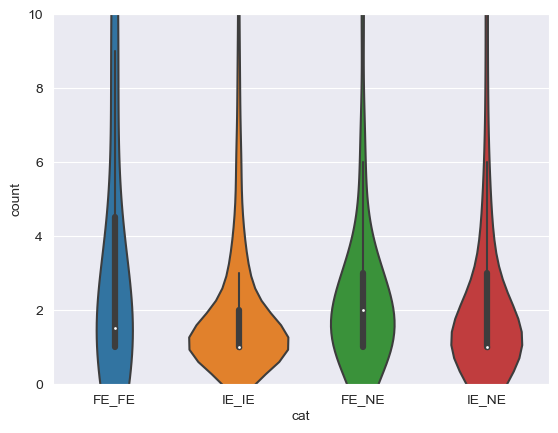

In [20]:
sns.violinplot(frame, x='cat', y='count', order=["FE_FE", "IE_IE", "FE_NE", "IE_NE"])

_ = plt.ylim(0, 10)
plt.savefig("figs/main4e.pdf")